PTH and PTH_FC data analysis 

Importing packages and making storage class

In [1]:
import pandas as pd
import csv
import string
import numpy as np
import matplotlib.pyplot as plt #for plotting
from lmfit import minimize, Parameters, Model, Parameter
import pandas as pd 
from IPython.display import display, HTML

In [2]:
#this is a class that stores the data corresponding to each curve or run in one place 
#it makes the code a little neater 
class Run:
    def __init__(self,name="",protein="",concentration=0,model="oneToone",t=[],r=[]):
        self.name = name 
        self.protein = protein 
        self.concentration = concentration
        self.model = model 
        self.t = t 
        self.r = r 
        self.fitResult = None 
        self.Rsqr = 0 
    

Loading the data

In [3]:
#making a file list 
letters = string.ascii_uppercase 
dataDir = 'C:/Users/dexte/Desktop/pdata/'
extension = ".xls"
fileNameList = []
for i in range(0,6):
    for j in range(1,5):
        tmpName = letters[i]+str(j)
        fileNameList.append(tmpName)
fileNameList.append('G1')
fileNameList.append('G3')
fileNameList.append('H1')
fileNameList.append('H3')
fileList = [] 
for name in fileNameList:
    fileList.append(dataDir+name+extension)

print(fileList)

['C:/Users/dexte/Desktop/pdata/A1.xls', 'C:/Users/dexte/Desktop/pdata/A2.xls', 'C:/Users/dexte/Desktop/pdata/A3.xls', 'C:/Users/dexte/Desktop/pdata/A4.xls', 'C:/Users/dexte/Desktop/pdata/B1.xls', 'C:/Users/dexte/Desktop/pdata/B2.xls', 'C:/Users/dexte/Desktop/pdata/B3.xls', 'C:/Users/dexte/Desktop/pdata/B4.xls', 'C:/Users/dexte/Desktop/pdata/C1.xls', 'C:/Users/dexte/Desktop/pdata/C2.xls', 'C:/Users/dexte/Desktop/pdata/C3.xls', 'C:/Users/dexte/Desktop/pdata/C4.xls', 'C:/Users/dexte/Desktop/pdata/D1.xls', 'C:/Users/dexte/Desktop/pdata/D2.xls', 'C:/Users/dexte/Desktop/pdata/D3.xls', 'C:/Users/dexte/Desktop/pdata/D4.xls', 'C:/Users/dexte/Desktop/pdata/E1.xls', 'C:/Users/dexte/Desktop/pdata/E2.xls', 'C:/Users/dexte/Desktop/pdata/E3.xls', 'C:/Users/dexte/Desktop/pdata/E4.xls', 'C:/Users/dexte/Desktop/pdata/F1.xls', 'C:/Users/dexte/Desktop/pdata/F2.xls', 'C:/Users/dexte/Desktop/pdata/F3.xls', 'C:/Users/dexte/Desktop/pdata/F4.xls', 'C:/Users/dexte/Desktop/pdata/G1.xls', 'C:/Users/dexte/Desktop/

In [4]:
#fileList = ['C:/Users/dexte/Desktop/pdata/A1.xls', 'C:/Users/dexte/Desktop/pdata/A2.xls', 'C:/Users/dexte/Desktop/pdata/A3.xls', 'C:/Users/dexte/Desktop/pdata/A4.xls', 'C:/Users/dexte/Desktop/pdata/B1.xls', 'C:/Users/dexte/Desktop/pdata/B2.xls', 'C:/Users/dexte/Desktop/pdata/B3.xls', 'C:/Users/dexte/Desktop/pdata/B4.xls', 'C:/Users/dexte/Desktop/pdata/C1.xls', 'C:/Users/dexte/Desktop/pdata/C2.xls', 'C:/Users/dexte/Desktop/pdata/C3.xls', 'C:/Users/dexte/Desktop/pdata/C4.xls', 'C:/Users/dexte/Desktop/pdata/D1.xls', 'C:/Users/dexte/Desktop/pdata/D2.xls', 'C:/Users/dexte/Desktop/pdata/D3.xls', 'C:/Users/dexte/Desktop/pdata/D4.xls', 'C:/Users/dexte/Desktop/pdata/E1.xls', 'C:/Users/dexte/Desktop/pdata/E2.xls', 'C:/Users/dexte/Desktop/pdata/E3.xls', 'C:/Users/dexte/Desktop/pdata/E4.xls', 'C:/Users/dexte/Desktop/pdata/F1.xls', 'C:/Users/dexte/Desktop/pdata/F2.xls', 'C:/Users/dexte/Desktop/pdata/F3.xls', 'C:/Users/dexte/Desktop/pdata/F4.xls', 'C:/Users/dexte/Desktop/pdata/F4.xls', 'C:/Users/dexte/Desktop/pdata/G1.xls', 'C:/Users/dexte/Desktop/pdata/G3.xls', 'C:/Users/dexte/Desktop/pdata/H1.xls', 'C:/Users/dexte/Desktop/pdata/H3.xls']
#this identifies the curves corresponding to PTF-Fc proteins. The other ones are the PTH
isFc = [0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1,0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1,0, 0, 1,0,1]

#this reads the data from all of the files, builds a Run object, and then stores it in the run_array object 
t_array = []
r_array = []
run_array = []
conc_array = []
run_num = 0
for file in fileList:
    with open(file,'r') as csvFile:
        rowNum = 1 
        fReader = csv.reader(csvFile)
        conc = 0 
        t = []
        r = []
        for row in fReader:
            if(rowNum==2):
                conc = row[0].split("\t")[1]
            if(rowNum >= 6): 
                t.append(float(row[0].split("\t")[0]))
                r.append(float(row[0].split("\t")[1]))


            rowNum = rowNum + 1 
    t_array.append(t)
    r_array.append(r)
    conc_array.append(conc)
    
    if(isFc[run_num]):
        protein_name = "PTH-Fc"
    else:
        protein_name = "PTH"
    
    tmpRun = Run(str(run_num),protein_name,conc,"oneToone",t,r)
    run_array.append(tmpRun)
    
    run_num = run_num + 1 


Making a PTH and PTH-Fc graph while ignoring the curves that have a max below 0.07 nm 

0 1E-05
4 6.7E-06
8 4.4E-06
12 3E-06
16 2E-06
20 1.3E-06
24 8.8E-07


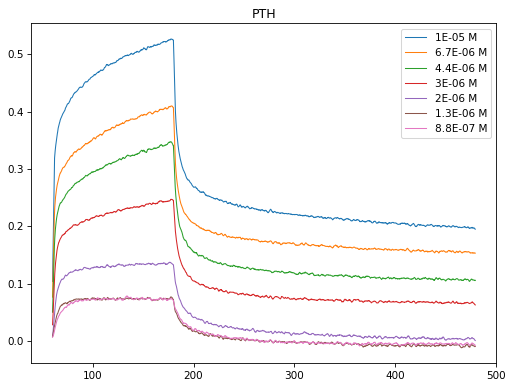

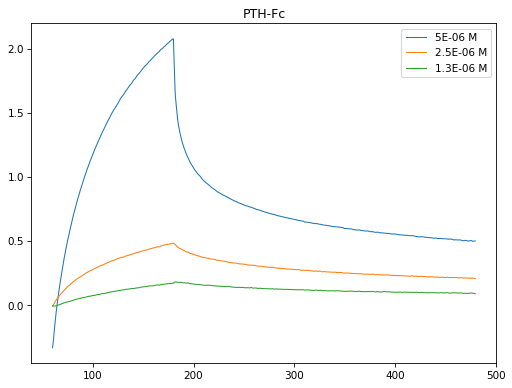

In [5]:
k=0
for run in run_array:
    if(run.protein == "PTH-Fc" and np.max(run.r)>0.07):
        plt.figure(1,figsize=(8, 6), dpi=75, facecolor='w', edgecolor='k')
        conc = run.concentration
        plt.plot(run.t,run.r,'-',linewidth=1,label=str(conc) + " M")
        plt.legend()
        plt.title("PTH-Fc")
    if(run.protein=="PTH" and np.max(run.r)>0.07):
        plt.figure(2,figsize=(8, 6), dpi=75, facecolor='w', edgecolor='k')
        conc = run.concentration
        plt.plot(run.t,run.r,'-',linewidth=1,label=str(conc) + " M")
        plt.legend()
        plt.title("PTH")
        print(k,conc) #this is for testing purposes to find the positions in run array that cor to PTH 
    k=k+1

#plt.figure(1)

#print(i,j)

In [6]:
#this peice of code is important. It locates the position where the max peak is reached 

i = np.max(run_array[0].r)
max_value = max(run_array[0].r)
max_index = run_array[0].r.index(max_value)
max_time = run_array[0].t[max_index]
tmax = max_time 


Now we are going to get involved in fitting!
First we will do the one-to-one fitting.
The one to one fitting follows the following model:  
$L+A \underset{k_a}{\stackrel{k_d}{\rightleftharpoons}} LA$
The differential equations for this model are:

$\begin{equation}
\frac{d[L]}{dt} = - (k_a[L][A]-k_d[LA])
\end{equation}$

$\begin{equation}
\frac{d[LA]}{dt}=k_a[L][A]-k_d[LA]
\end{equation}$

The integrated equations that we will be fitting to the models are shown below 

for the absorption part: 

$R = R_{eq}(1-e^{-(k_aC+k_d)(t-t_0)})$

for the desportion part: 

$R=R_{0}e^{-k_d(t-t_0)}$

$R_{0} = R_{absFit}(t_{change over})$


$R_{eq} = \frac{k_aC}{k_aC+k_d}R_{max}$

So the variables varried in the fit are $R_{max}$, $k_d$ and $k_a$

Here we fit the ODE version of the 1:1 to ensure that this works .


50


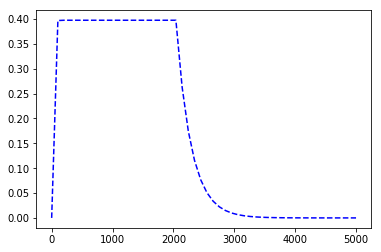

In [7]:
#here is a function that uses scipi to numerically integrate the ODEs
#this returns the same value as when fitting to the analytical solution 

from scipy.integrate import odeint
def derAbsDes(t,ka,kd,Rmax,A0,t0,tmax,imax):
    abserr = 1.0e-8
    relerr = 1.0e-6
    t_abs = t[0:imax]
    t_des = t[imax:None]

    def deriv_LLa(conc,t,params):
        kd,ka,A0 = params 
        L,LA = conc 
        #ODEs 
        dLA = ka*A0*L - kd*LA 
        dL = -dLA
        
        f = [dL, dLA]
        return f 

    #paramaters 
    params = [kd,ka,A0]
    Wtotal = []

    #intial conditions for absorption section 
    L0_abs = Rmax
    LA_abs = 0 
    conc0_abs = [L0_abs,LA_abs]
    wsol_abs = odeint(deriv_LLa, conc0_abs, t_abs, args=(params,),atol=abserr, rtol=relerr)
    
    Wtotal.extend(wsol_abs[:,1])

    #initial conditions for the desportion section 
    L0_des = 0
    params = [kd,ka,0]
    LA_des = Wtotal[-1] #CHANGE LATER 
    conc0_des = [L0_des,LA_des]
    
    wsol_des = odeint(deriv_LLa, conc0_des, t_des, args=(params,),atol=abserr, rtol=relerr)
    
    Wtotal.extend(wsol_des[:,1])

    #print(Wtotal)
    return Wtotal

#for testing that this function works 
t = np.linspace(0,5000)
ka = 5.959682e+04
kd = 4.037493e-03
Rmax = 4.242651e-01
A0 = 1e-6 
t0 = 0 
tmax = t[-1]
imax = 20 

sol =  derAbsDes(t,ka,kd,Rmax,A0,t0,tmax,imax)
#print(len(sol))
print(len(t))
plt.plot(t,sol,'b--')

In [8]:
i = np.max(run_array[0].r)
max_value = max(run_array[0].r)
max_index = run_array[0].r.index(max_value)
max_time = run_array[0].t[max_index]
tmax = max_time 

#absorption and desoprtion combined together 

#parameters from BLI program's global fit for initial guess for one of the fittings 
#this provides a good starting point for all of the graphs 

kon = 9.32e4
kdis = 3.45e-2
Rmaxf = 0.1551 

for aRun in run_array: 
    tmpRun = aRun
    tp = np.array(tmpRun.t) #max index only fits first part 
    rp = np.array(tmpRun.r)
    A0 = float(tmpRun.concentration)
    t0 = tp[0]

    def absdes(t,ka,kd,Rmax,A0,t0,tmax,imax):#absoprtion and desoprtion 
        np.zeros(len(t))
        tOnes = np.ones(len(t))
        isAbs = np.asarray(t)<tmax
        isDes =  np.invert(isAbs)
        Rest_abs = Rmax*((ka*A0)/(ka*A0+kd))*(1-np.exp(-(ka*A0+kd)*(t-t0)))
        R0 = Rest_abs[imax]
        Rest_des = R0*( np.exp(-kd*(t-tmax)*isDes) )
        return Rest_abs*isAbs +Rest_des*isDes

    aModel = Model(absdes)
    #aModel = Model(derAbsDes) unselect to use the numerical integration version 
    #they give the same answers 
    
    params = aModel.make_params()
    params["kd"] = Parameter(name="kd",value=kdis,min=0)
    params["ka"] = Parameter(name="ka",value=kon,min=0)
    params["Rmax"] = Parameter(name="Rmax",value=Rmaxf,min=0)

    params["A0"] = Parameter(name="A0",value=A0,vary=False) 
    params["t0"] = Parameter(name="t0",value=t0,vary=False) 
    params["tmax"] = Parameter(name="tmax",value=tmax,vary=False) 
    params["imax"] = Parameter(name="imax",value=max_index,vary=False) 

    result = aModel.fit(rp,params,t=tp)
    aRun.Rsqr = 1 - result.residual.var() / np.var(rp)
    aRun.fitResult = result


In [9]:
#make a nice pandas dataframe 
#first make a dictionary

output = {} #{"fileName","Protein Name","Concentration (M)","KD","ka","ka error","kd","kd error","Rmax","Rmax error","R^2"}
i = 0 
titleList = ["File Name","Protein Name","Concentration (M)","KD","ka","ka error","KD error","kd","kd error","Rmax","Rmax error","R^2"]
#initilize dictionary list 
for name in titleList:
    output[name] = []
#fill it with data 
for run in run_array:
    output["File Name"].append(fileNameList[i])
    output["Protein Name"].append(run.protein)
    output["Concentration (M)"].append(run.concentration)
    output["KD"].append(run.fitResult.params["kd"].value/run.fitResult.params["ka"].value)
    output["KD error"].append(0)
    output["ka"].append(run.fitResult.params["ka"].value)
    #output["ka"] = run.fitResult.params["ka"].
    output["ka error"].append(run.fitResult.params["ka"].stderr)
    output["kd"].append(run.fitResult.params["kd"].value)
    output["kd error"].append(run.fitResult.params["kd"].stderr)
    output["Rmax"].append(run.fitResult.params["Rmax"].value)
    output["Rmax error"].append(run.fitResult.params["Rmax"].stderr)
    output["R^2"].append(run.Rsqr)
    #output["R^2"] =  1 - result.residual.var() / np.var(y)
   
    i = i + 1 
#header = ["fileName","Protein Name","Concentration (M)","KD (m)","ka 1/(M*s)","ka error","kd","kd error","Rmax","Rmax error","R^2"]
#header.append(np.zeros(11))
#fittingOutput = pd.DataFrame(columns=header)

#newCol = pd.DataFrame(header,columns=header)
#display(fittingOutput.head())

#df1 = pd.DataFrame(columns=list('AB'))
#df2 = pd.DataFrame(np.zeros(2))
#df1.append(np.zeros(2))
#print(df1)
#print(fittingOutput)

x = pd.DataFrame.from_dict(output)  
x["KD error"] = np.sqrt((x["kd error"]/x["kd"])**2 + (x["ka error"]/x["ka"])**2)*x["KD"]
x.to_csv("PythonFittingOutput_regular.csv")
x

,File Name,Protein Name,Concentration (M),KD,ka,ka error,KD error,kd,kd error,Rmax,Rmax error,R^2
0,A1,PTH,1E-05,6.774679e-08,5.959682e+04,6.363912e+03,7.310710e-09,4.037493e-03,6.287447e-05,4.242651e-01,2.391693e-03,7.089889e-01
1,A2,PTH,3.9E-07,2.112055e-07,3.233034e+05,3.166895e+04,2.198743e-08,6.828345e-02,2.407123e-03,4.178982e-02,1.766651e-03,9.473516e-01
2,A3,PTH-Fc,5E-06,1.074555e-06,5.627028e+03,2.324499e+02,4.681296e-08,6.046552e-03,8.365889e-05,1.971514e+00,3.258310e-02,8.071796e-01
3,A4,PTH-Fc,2E-08,1.123047e-06,1.959905e+05,NaN,NaN,2.201066e-01,NaN,2.976730e-12,NaN,6.642908e-12
4,B1,PTH,6.7E-06,5.363825e-08,7.445384e+04,7.531189e+03,5.494331e-09,3.993574e-03,6.448301e-05,3.255822e-01,1.912546e-03,6.919179e-01
5,B2,PTH,2.6E-07,2.767840e-09,3.383074e+05,9.093993e+03,1.038237e-10,9.363810e-04,2.449801e-05,3.681801e-02,1.387905e-04,5.650504e-01
6,B3,PTH-Fc,2.5E-06,3.126368e-07,9.201671e+03,1.319500e+02,4.939849e-09,2.876781e-03,1.908879e-05,5.038379e-01,2.881640e-03,9.465479e-01
7,B4,PTH-Fc,9.8E-09,6.432630e-09,6.730030e+06,1.408096e+05,1.420070e-10,4.329180e-02,3.048846e-04,9.006487e-02,9.458156e-04,9.933895e-01
8,C1,PTH,4.4E-06,6.179388e-08,8.836754e+04,8.497717e+03,6.022840e-09,5.460573e-03,8.674511e-05,2.755590e-01,1.828766e-03,7.282265e-01
9,C2,PTH,1.7E-07,2.102649e-09,3.361230e+06,6.046192e+05,3.816890e-10,7.067488e-03,1.724455e-04,1.024078e-02,1.060962e-04,5.357322e-01


now we plot each graph with its fit

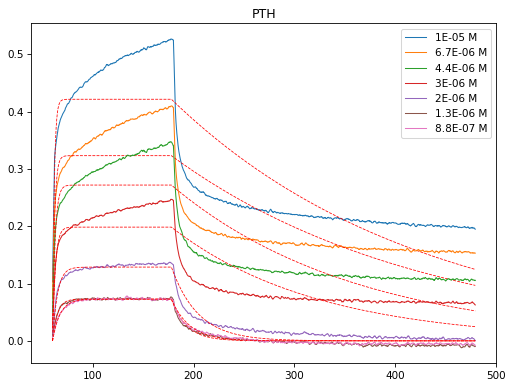

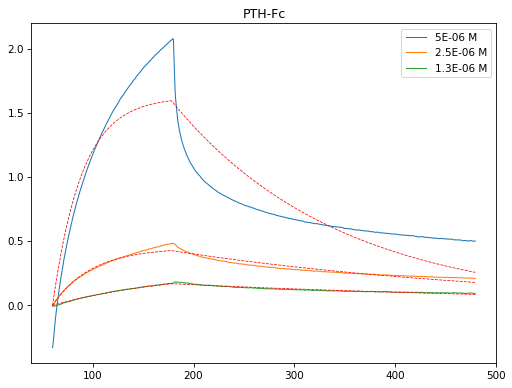

In [10]:
#KdDic = {}
for run in run_array:
    if(run.protein == "PTH-Fc" and np.max(run.r)>0.07):
        plt.figure(1,figsize=(8, 6), dpi=75, facecolor='w', edgecolor='k')
        conc = run.concentration
        plt.plot(run.t,run.r,'-',linewidth=1,label=str(conc) + " M")
        plt.plot(run.t,run.fitResult.best_fit,"--r",linewidth=0.75)
        plt.legend()
        plt.title("PTH-Fc")
        #print(run.fitResult.fit_report())
        #KdDic[run.fitResult.params["A0"].value]= run.fitResult.params["kd"].value/run.fitResult.params["ka"].value

    if(run.protein=="PTH" and np.max(run.r)>0.07):
        plt.figure(2,figsize=(8, 6), dpi=75, facecolor='w', edgecolor='k')
        conc = run.concentration
        plt.plot(run.t,run.r,'-',linewidth=1,label=str(conc) + " M")
        plt.plot(run.t,run.fitResult.best_fit,"--r",linewidth=0.75)
        plt.legend()
        plt.title("PTH")
        #KdDic[run.fitResult.params["A0"].value]= run.fitResult.params["kd"].value/run.fitResult.params["ka"].value
        #print(run.fitResult.fit_report())
# print("KD is \n")
# print("  conc              KD")
# import pprint
# pprint.pprint(KdDic)
# pretty_dict_str = pprint.pformat(KdDic)


Now that we have done the one-to-one fitting we move onto some other models. I tried the bivalant analyte model in the program but it didn't work that well. I am now going to try fitting a second model. This model takes into account the secondary interactions between the probe and the solution. We will see if this ends up working.

The one to one fitting follows the following model:  
$L+A \underset{k_a}{\stackrel{k_d}{\rightleftharpoons}} LA$
$L+S \underset{k_as}{\stackrel{k_ds}{\rightleftharpoons}} LS$

The differential equations for this model are:

$\begin{equation}
\frac{d[L]}{dt} = - (k_a[L][A]-k_d[LA])- (k_as[L][S]-k_ds[LS])
\end{equation}$

$\begin{equation}
\frac{d[LA]}{dt}=k_a[L][A]-k_d[LA]
\end{equation}$

$\begin{equation}
\frac{d[LS]}{dt}=k_as[L][S]-k_ds[LS]
\end{equation}$



50


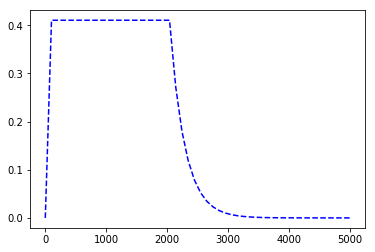

In [11]:
def derSecondary(t,ka,kd,kas,kds,Rmax,A0,t0,tmax,imax):
    abserr = 1.0e-8
    relerr = 1.0e-6
    t_abs = t[0:imax]
    t_des = t[imax:None]

    def deriv_LLa(conc,t,params):
        kd,ka,A0,kds,kas = params 
        L,LA,LS = conc 
        #ODEs 
        dLA = ka*A0*L - kd*LA 
        dLS = kas*A0*L - kds*LS
        dL = -dLA-dLS
        
        f = [dL, dLA,dLS]
        return f 

    #paramaters 
    params = [kd,ka,A0,kds,kas]
    Wtotal = []

    #intial conditions for absorption section 
    L0_abs = Rmax
    LA0_abs = 0 
    LS0_abs = 0 
    conc0_abs = [L0_abs,LA0_abs,LS0_abs]
    wsol_abs = odeint(deriv_LLa, conc0_abs, t_abs, args=(params,),atol=abserr, rtol=relerr)
    Wtotal.extend(wsol_abs[:,1]+wsol_abs[:,2])

    #initial conditions for the desportion section 
    L0_des = 0
    params = [kd,ka,0,kds,kas]
    LA_des = wsol_abs[len(wsol_abs)-1,1]
    #print(len(wsol_abs))
    LS_des = wsol_abs[len(wsol_abs)-1,2]
    
    conc0_des = [L0_des,LA_des,LS_des]
    
    wsol_des = odeint(deriv_LLa, conc0_des, t_des, args=(params,),atol=abserr, rtol=relerr)
    
    Wtotal.extend(wsol_des[:,1]+wsol_des[:,2])

    #print(Wtotal)
    return Wtotal

#for testing that this function works 
t = np.linspace(0,5000)
ka = 5.959682e+04
kd = 4.037493e-03
kas = ka
kds = kd 
Rmax = 4.242651e-01
A0 = 1e-6 
t0 = 0 
tmax = t[-1]
imax = 20 

sol =  derSecondary(t,ka,kd,kas,kds,Rmax,A0,t0,tmax,imax)
#print(len(sol))
print(len(t))
plt.plot(t,sol,'b--')

In [12]:
i = np.max(run_array[0].r)
max_value = max(run_array[0].r)
max_index = run_array[0].r.index(max_value)
max_time = run_array[0].t[max_index]
tmax = max_time 

#absorption and desoprtion combined together 

#parameters from BLI program's global fit for initial guess for one of the fittings 
#this provides a good starting point for all of the graphs 

kon = 9.32e4
kdis = 3.45e-2
kas = ka/100
kds = kd*100

Rmaxf = 0.1551 

for aRun in run_array: 
    tmpRun = aRun
    tp = np.array(tmpRun.t) #max index only fits first part 
    rp = np.array(tmpRun.r)
    A0 = float(tmpRun.concentration)
    t0 = tp[0]

    aModel = Model(derSecondary)
    #aModel = Model(derAbsDes) unselect to use the numerical integration version 
    #they give the same answers 
    
    params = aModel.make_params()
    params["kd"] = Parameter(name="kd",value=kdis,min=0)
    params["ka"] = Parameter(name="ka",value=kon,min=0)
    params["kds"] = Parameter(name="kd",value=kdis,min=0)
    params["kas"] = Parameter(name="ka",value=kon,min=0)

    params["Rmax"] = Parameter(name="Rmax",value=Rmaxf,min=0)

    params["A0"] = Parameter(name="A0",value=A0,vary=False) 
    params["t0"] = Parameter(name="t0",value=t0,vary=False) 
    params["tmax"] = Parameter(name="tmax",value=tmax,vary=False) 
    params["imax"] = Parameter(name="imax",value=max_index,vary=False) 

    result = aModel.fit(rp,params,t=tp)
    aRun.Rsqr = 1 - result.residual.var() / np.var(rp)
    aRun.fitResult = result


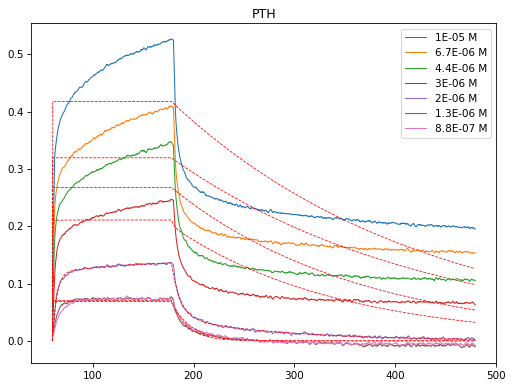

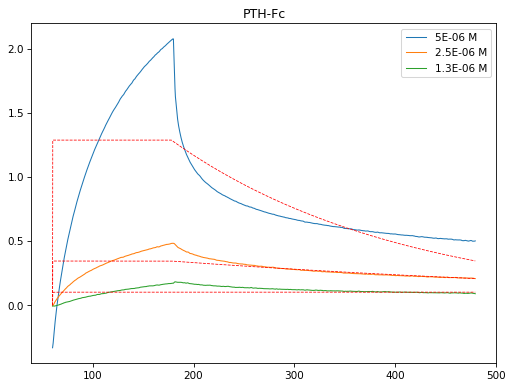

In [13]:
for run in run_array:
    if(run.protein == "PTH-Fc" and np.max(run.r)>0.07):
        plt.figure(1,figsize=(8, 6), dpi=75, facecolor='w', edgecolor='k')
        conc = run.concentration
        plt.plot(run.t,run.r,'-',linewidth=1,label=str(conc) + " M")
        plt.plot(run.t,run.fitResult.best_fit,"--r",linewidth=0.75)
        plt.legend()
        plt.title("PTH-Fc")
        #print(run.fitResult.fit_report())
        #KdDic[run.fitResult.params["A0"].value]= run.fitResult.params["kd"].value/run.fitResult.params["ka"].value

    if(run.protein=="PTH" and np.max(run.r)>0.07):
        plt.figure(2,figsize=(8, 6), dpi=75, facecolor='w', edgecolor='k')
        conc = run.concentration
        plt.plot(run.t,run.r,'-',linewidth=1,label=str(conc) + " M")
        plt.plot(run.t,run.fitResult.best_fit,"--r",linewidth=0.75)
        plt.legend()
        plt.title("PTH")

In [14]:
#make a nice pandas dataframe 
#first make a dictionary

output_m2 = {} #{"fileName","Protein Name","Concentration (M)","KD","ka","ka error","kd","kd error","Rmax","Rmax error","R^2"}
i = 0 
titleList = ["File Name","Protein Name","Concentration (M)","KD","ka","ka error","KD error","kd","kd error","kas","kas error","kds","kds error","Rmax","Rmax error","R^2"]
#initilize dictionary list 
for name in titleList:
    output_m2[name] = []
#fill it with data 
for run in run_array:
    output_m2["File Name"].append(fileNameList[i])
    output_m2["Protein Name"].append(run.protein)
    output_m2["Concentration (M)"].append(run.concentration)
    output_m2["KD"].append(run.fitResult.params["kd"].value/run.fitResult.params["ka"].value)
    output_m2["KD error"].append(0)
    output_m2["ka"].append(run.fitResult.params["ka"].value)
    #output["ka"] = run.fitResult.params["ka"].
    output_m2["ka error"].append(run.fitResult.params["ka"].stderr)
    output_m2["kd"].append(run.fitResult.params["kd"].value)
    output_m2["kd error"].append(run.fitResult.params["kd"].stderr)
    
    
    output_m2["kas"].append(run.fitResult.params["kas"].value)
    output_m2["kas error"].append(run.fitResult.params["kas"].stderr)
    output_m2["kds"].append(run.fitResult.params["kds"].value)
    output_m2["kds error"].append(run.fitResult.params["kds"].stderr)


    output_m2["Rmax"].append(run.fitResult.params["Rmax"].value)
    output_m2["Rmax error"].append(run.fitResult.params["Rmax"].stderr)
    output_m2["R^2"].append(run.Rsqr)
    #output["R^2"] =  1 - result.residual.var() / np.var(y)
   
    i = i + 1 
#header = ["fileName","Protein Name","Concentration (M)","KD (m)","ka 1/(M*s)","ka error","kd","kd error","Rmax","Rmax error","R^2"]
#header.append(np.zeros(11))
#fittingOutput = pd.DataFrame(columns=header)

#newCol = pd.DataFrame(header,columns=header)
#display(fittingOutput.head())

#df1 = pd.DataFrame(columns=list('AB'))
#df2 = pd.DataFrame(np.zeros(2))
#df1.append(np.zeros(2))
#print(df1)
#print(fittingOutput)

x = pd.DataFrame.from_dict(output_m2)  
x["KD error"] = np.sqrt((x["kd error"]/x["kd"])**2 + (x["ka error"]/x["ka"])**2)*x["KD"]
x.to_csv("PythonFittingOutput_regular.csv")
x

,File Name,Protein Name,Concentration (M),KD,ka,ka error,KD error,kd,kd error,kas,kas error,kds,kds error,Rmax,Rmax error,R^2
0,A1,PTH,1E-05,1.117006e-11,3.560869e+08,1.898956e+10,5.956819e-10,3.977513e-03,8.908816e-05,9.005415e+07,1.290085e+09,2.442848e+02,9.819688e+03,4.175628e-01,2.309573e-03,6.933377e-01
1,A2,PTH,3.9E-07,5.526478e-05,1.519652e+06,1.327038e+12,8.139886e+01,8.398321e+01,9.961245e+07,6.470161e+06,NaN,8.460335e+01,1.768466e+07,7.354012e-01,NaN,8.568403e-01
2,A3,PTH-Fc,5E-06,1.217292e-11,3.573671e+08,4.252689e+09,1.448593e-10,4.350200e-03,1.811864e-04,4.242381e+08,7.944986e+10,4.320628e+01,3.593598e+02,1.286967e+00,1.404836e-02,4.814902e-01
3,A4,PTH-Fc,2E-08,4.514003e-06,6.004734e+04,6.028369e+12,NaN,2.710538e-01,NaN,6.004620e+04,6.042960e+12,2.710539e-01,NaN,2.905322e-07,9.506409e-01,1.576407e-07
4,B1,PTH,6.7E-06,3.770422e-07,1.452897e+09,3.200356e+10,8.309626e-06,5.478037e+02,3.912894e+02,1.110608e+08,6.156268e+08,3.908835e-03,7.844604e-05,3.193020e-01,2.121067e-03,6.726959e-01
5,B2,PTH,2.6E-07,1.277345e-06,3.917930e+07,8.160732e+13,3.523356e+00,5.004548e+01,9.049663e+07,3.890074e+07,1.147642e+14,4.942139e+01,8.230861e+07,1.227964e-01,1.577387e+05,-7.336532e+00
6,B3,PTH-Fc,2.5E-06,6.201185e-12,2.688040e+08,3.071965e+11,7.086880e-09,1.666903e-03,1.100667e-04,2.379410e+08,2.629882e+11,3.822976e+01,1.545988e+04,3.453735e-01,2.689426e-03,3.001601e-01
7,B4,PTH-Fc,9.8E-09,1.359829e-08,5.298699e+06,1.025819e+05,3.501209e-10,7.205326e-02,1.223054e-03,3.745024e+05,2.155446e+04,1.382091e-02,4.191897e-04,1.148315e-01,1.588323e-03,9.963193e-01
8,C1,PTH,4.4E-06,1.080636e-11,4.925810e+08,9.114095e+09,1.999476e-10,5.323010e-03,1.825509e-04,2.427507e+08,5.619589e+09,1.113470e+02,5.877666e+02,2.674756e-01,1.720429e-03,7.075336e-01
9,C2,PTH,1.7E-07,1.403207e-05,4.225828e+06,4.345805e+12,2.267237e+01,5.929712e+01,7.389740e+07,5.390617e+06,1.615922e+13,5.662693e+01,3.026489e+07,4.224817e-01,7.190438e+05,6.001154e-01


50


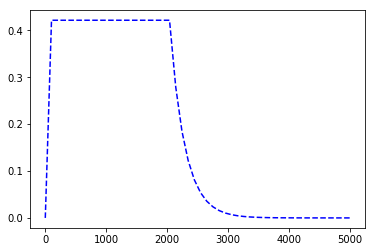

In [15]:
def derModel3(t,ka,kd,kas,kds,Rmax,A0,t0,tmax,imax):
    abserr = 1.0e-8
    relerr = 1.0e-6
    t_abs = t[0:imax]
    t_des = t[imax:None]

    def deriv_LLa(conc,t,params):
        kd,ka,A0,kds,kas = params 
        L,LA,LS = conc 
        #ODEs 
        dLA = ka*A0*L - kd*LA 
        dLS = kas*A0 - kds*LS
        dL = -dLA
        
        f = [dL, dLA,dLS]
        return f 

    #paramaters 
    params = [kd,ka,A0,kds,kas]
    Wtotal = []

    #intial conditions for absorption section 
    L0_abs = Rmax
    LA0_abs = 0 
    LS0_abs = 0 
    conc0_abs = [L0_abs,LA0_abs,LS0_abs]
    wsol_abs = odeint(deriv_LLa, conc0_abs, t_abs, args=(params,),atol=abserr, rtol=relerr)
    Wtotal.extend(wsol_abs[:,1]+wsol_abs[:,2])

    #initial conditions for the desportion section 
    L0_des = 0
    params = [kd,ka,0,kds,kas]
    LA_des = wsol_abs[len(wsol_abs)-1,1]
    #print(len(wsol_abs))
    LS_des = wsol_abs[len(wsol_abs)-1,2]
    
    conc0_des = [L0_des,LA_des,LS_des]
    
    wsol_des = odeint(deriv_LLa, conc0_des, t_des, args=(params,),atol=abserr, rtol=relerr)
    
    Wtotal.extend(wsol_des[:,1]+wsol_des[:,2])

    #print(Wtotal)
    return Wtotal

#for testing that this function works 
t = np.linspace(0,5000)
ka = 5.959682e+04/100
kd = 4.037493e-03
kas = ka*1000
kds = kd
Rmax = 4.242651e-01
A0 = 1e-6 
t0 = 0 
tmax = t[-1]
imax = 20 

sol =  derSecondary(t,ka,kd,kas,kds,Rmax,A0,t0,tmax,imax)
#print(len(sol))
print(len(t))
plt.plot(t,sol,'b--')

In [16]:
i = np.max(run_array[0].r)
max_value = max(run_array[0].r)
max_index = run_array[0].r.index(max_value)
max_time = run_array[0].t[max_index]
tmax = max_time 

#absorption and desoprtion combined together 

#parameters from BLI program's global fit for initial guess for one of the fittings 
#this provides a good starting point for all of the graphs 

kon = 9.32e4
kdis = 3.45e-2
kas = ka
kds = kd

Rmaxf = 0.1551 

for aRun in run_array: 
    tmpRun = aRun
    tp = np.array(tmpRun.t) #max index only fits first part 
    rp = np.array(tmpRun.r)
    A0 = float(tmpRun.concentration)
    t0 = tp[0]

    aModel = Model(derModel3)
    #aModel = Model(derAbsDes) unselect to use the numerical integration version 
    #they give the same answers 
    
    params = aModel.make_params()
    params["kd"] = Parameter(name="kd",value=kdis,min=0)
    params["ka"] = Parameter(name="ka",value=kon,min=0)
    params["kds"] = Parameter(name="kd",value=kdis,min=0)
    params["kas"] = Parameter(name="ka",value=kon,min=0)

    params["Rmax"] = Parameter(name="Rmax",value=Rmaxf,min=0)

    params["A0"] = Parameter(name="A0",value=A0,vary=False) 
    params["t0"] = Parameter(name="t0",value=t0,vary=False) 
    params["tmax"] = Parameter(name="tmax",value=tmax,vary=False) 
    params["imax"] = Parameter(name="imax",value=max_index,vary=False) 

    result = aModel.fit(rp,params,t=tp)
    aRun.Rsqr = 1 - result.residual.var() / np.var(rp)
    aRun.fitResult = result


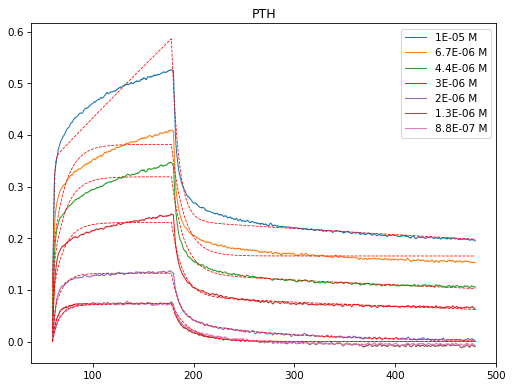

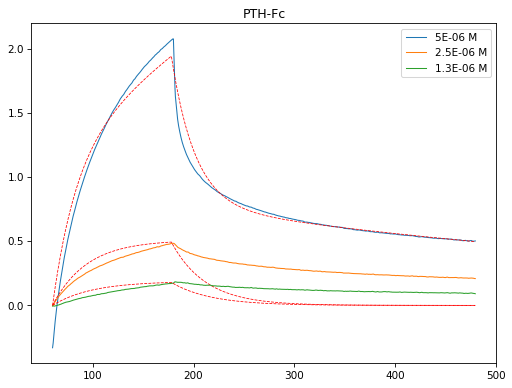

In [17]:
for run in run_array:
    if(run.protein == "PTH-Fc" and np.max(run.r)>0.07):
        plt.figure(1,figsize=(8, 6), dpi=75, facecolor='w', edgecolor='k')
        conc = run.concentration
        plt.plot(run.t,run.r,'-',linewidth=1,label=str(conc) + " M")
        plt.plot(run.t,run.fitResult.best_fit,"--r",linewidth=0.75)
        plt.legend()
        plt.title("PTH-Fc")
        #print(run.fitResult.fit_report())
        #KdDic[run.fitResult.params["A0"].value]= run.fitResult.params["kd"].value/run.fitResult.params["ka"].value

    if(run.protein=="PTH" and np.max(run.r)>0.07):
        plt.figure(2,figsize=(8, 6), dpi=75, facecolor='w', edgecolor='k')
        conc = run.concentration
        plt.plot(run.t,run.r,'-',linewidth=1,label=str(conc) + " M")
        plt.plot(run.t,run.fitResult.best_fit,"--r",linewidth=0.75)
        plt.legend()
        plt.title("PTH")

In [18]:
################
################
################



In [19]:
#make a nice pandas dataframe 
#first make a dictionary

output_m2 = {} #{"fileName","Protein Name","Concentration (M)","KD","ka","ka error","kd","kd error","Rmax","Rmax error","R^2"}
i = 0 
titleList = ["File Name","Protein Name","Concentration (M)","KD","ka","ka error","KD error","kd","kd error","kas","kas error","kds","kds error","Rmax","Rmax error","R^2"]
#initilize dictionary list 
for name in titleList:
    output_m2[name] = []
#fill it with data 
for run in run_array:
    output_m2["File Name"].append(fileNameList[i])
    output_m2["Protein Name"].append(run.protein)
    output_m2["Concentration (M)"].append(run.concentration)
    output_m2["KD"].append(run.fitResult.params["kd"].value/run.fitResult.params["ka"].value)
    output_m2["KD error"].append(0)
    output_m2["ka"].append(run.fitResult.params["ka"].value)
    #output["ka"] = run.fitResult.params["ka"].
    output_m2["ka error"].append(run.fitResult.params["ka"].stderr)
    output_m2["kd"].append(run.fitResult.params["kd"].value)
    output_m2["kd error"].append(run.fitResult.params["kd"].stderr)
    
    
    output_m2["kas"].append(run.fitResult.params["kas"].value)
    output_m2["kas error"].append(run.fitResult.params["kas"].stderr)
    output_m2["kds"].append(run.fitResult.params["kds"].value)
    output_m2["kds error"].append(run.fitResult.params["kds"].stderr)


    output_m2["Rmax"].append(run.fitResult.params["Rmax"].value)
    output_m2["Rmax error"].append(run.fitResult.params["Rmax"].stderr)
    output_m2["R^2"].append(run.Rsqr)
    #output["R^2"] =  1 - result.residual.var() / np.var(y)
   
    i = i + 1 
#header = ["fileName","Protein Name","Concentration (M)","KD (m)","ka 1/(M*s)","ka error","kd","kd error","Rmax","Rmax error","R^2"]
#header.append(np.zeros(11))
#fittingOutput = pd.DataFrame(columns=header)

#newCol = pd.DataFrame(header,columns=header)
#display(fittingOutput.head())

#df1 = pd.DataFrame(columns=list('AB'))
#df2 = pd.DataFrame(np.zeros(2))
#df1.append(np.zeros(2))
#print(df1)
#print(fittingOutput)

x = pd.DataFrame.from_dict(output_m2)  
x["KD error"] = np.sqrt((x["kd error"]/x["kd"])**2 + (x["ka error"]/x["ka"])**2)*x["KD"]
x.to_csv("PythonFittingOutput_regular.csv")
x

,File Name,Protein Name,Concentration (M),KD,ka,ka error,KD error,kd,kd error,kas,kas error,kds,kds error,Rmax,Rmax error,R^2
0,A1,PTH,1E-05,1.477700e-06,9.633556e+04,5.253010e+03,8.551484e-08,1.423551e-01,2.759021e-03,205.316894,1.212770e+00,5.532959e-04,2.613569e-05,0.404047,0.003283,9.783198e-01
1,A2,PTH,3.9E-07,2.739684e-07,2.557686e+05,NaN,NaN,7.007253e-02,NaN,0.021608,NaN,5.915874e-02,NaN,0.046409,NaN,9.464527e-01
2,A3,PTH-Fc,5E-06,4.360636e-02,9.787451e-01,1.711105e-01,7.655100e-03,4.267951e-02,6.795987e-04,1444.358114,2.193589e+01,1.496784e-03,6.196181e-05,10185.106926,1776.991568,9.740608e-01
3,A4,PTH-Fc,2E-08,2.473052e-05,3.978684e+03,4.119694e+09,2.560701e+01,9.839494e-02,9.155335e+01,0.002903,3.424093e+04,7.356766e-02,1.517861e+06,0.010161,10514.030672,9.343423e-04
4,B1,PTH,6.7E-06,1.946559e-12,4.599398e+05,4.678041e+01,3.629987e-16,8.953001e-07,1.399383e-10,2565.876739,3.001952e-01,7.955282e-02,1.150507e-05,0.165749,0.000029,9.796231e-01
5,B2,PTH,2.6E-07,1.087616e-07,1.072457e+06,NaN,NaN,1.166422e-01,NaN,979.810682,NaN,2.277293e-09,NaN,0.029469,NaN,8.151393e-01
6,B3,PTH-Fc,2.5E-06,5.249404e-07,4.577665e+05,5.996808e+06,4.220750e-05,2.403001e-01,1.906301e+01,5948.629245,7.789639e+02,2.930404e-02,2.933967e-03,0.002013,0.042498,-1.279278e+00
7,B4,PTH-Fc,9.8E-09,5.288030e-10,3.021866e+07,1.931677e+06,3.528765e-11,1.597972e-02,3.060686e-04,304536.059839,2.745762e+03,7.561528e-02,5.898424e-04,0.016689,0.000384,9.961513e-01
8,C1,PTH,4.4E-06,2.882190e-09,2.864293e+05,5.558470e+03,1.077269e-10,8.255439e-04,2.637127e-05,3423.747784,3.200529e+01,8.038249e-02,8.150757e-04,0.131779,0.000603,9.872804e-01
9,C2,PTH,1.7E-07,5.075027e-08,2.717062e+06,NaN,NaN,1.378916e-01,NaN,180.890911,NaN,1.999209e-09,NaN,0.012824,NaN,8.430086e-01


Now we will fit the bivalent analyite model to the data. This didn't give that great of fitting results, but I think we should use it for completenses. 
